In [72]:
using Plots
using LinearAlgebra
using StaticArrays

In [73]:
function frontwheel_dynamics(x, u, params)
    e = x[1]
    ψ = x[2]
    δ = u[1]
    l = params.l
    v = params.v

    return SVector{2}(
        v * sin(ψ - δ),
        -(v/l) * sin(δ)
    )
end

frontwheel_dynamics (generic function with 1 method)

In [74]:
function rk4(xₖ, uₖ, dt, dynamics::F, params) where {F}
    k1 = dynamics(xₖ, uₖ, params)
    k2 = dynamics(xₖ + k1*dt/2, uₖ, params)
    k3 = dynamics(xₖ + k2*dt/2, uₖ, params)
    k4 = dynamics(xₖ + k3*dt, uₖ, params)

    xₖ₊₁ = xₖ + dt * (k1 + 2k2 + 2k3 + k4) / 6
    return xₖ₊₁
end

function step(x, u, dt, params)
    return rk4(x, u, dt, frontwheel_dynamics, params)
end

step (generic function with 1 method)

In [75]:
function stanley_steering(x, params)
    e = x[1]
    ψ = x[2]

    k = params.k
    v = params.v
    δₘₐₓ = params.δₘₐₓ

    δ = ψ + atan(k * e / v)
    δ = clamp(δ, -δₘₐₓ, δₘₐₓ)
    return SVector{1}(δ)
end

stanley_steering (generic function with 1 method)

In [76]:
function sim_disturbance(x₀, tf, dt, params)
    Nk = ceil(Int, tf / dt) + 1     # Total runtime in timesteps

    delay = params.delay
    delay_k = round(Int, delay / dt) # Delay in discrete time increments

    X = zeros(2, Nk)
    X[:, 1] .= x₀

    for k in 1:(Nk-1)
        k_sense = max(k - delay_k, 1)
        u = stanley_steering(@view(X[:, k_sense]), params)
        X[:, k+1] .= step(@view(X[:, k]), u, dt, params)
    end

    return X
end

sim_disturbance (generic function with 1 method)

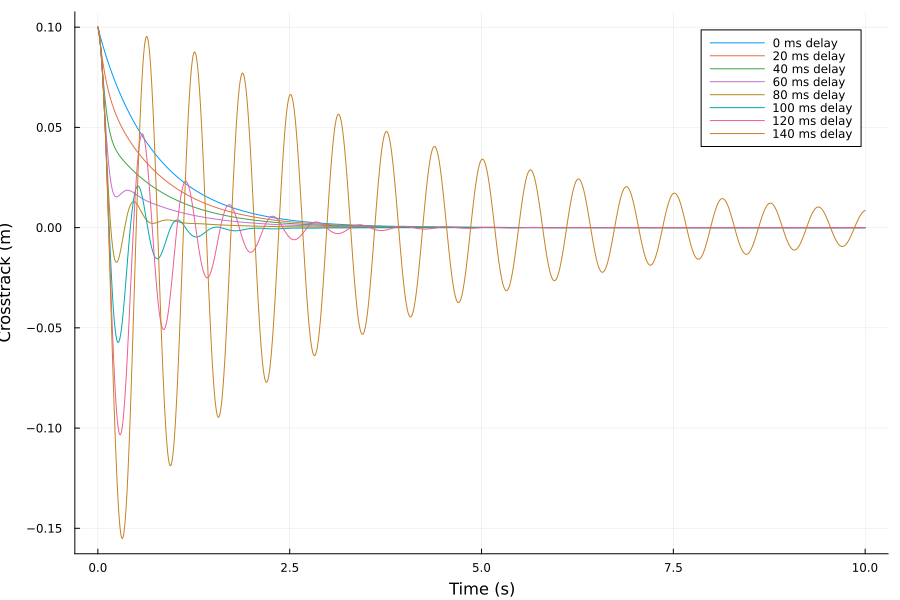

In [ ]:
tf = 10.0           # Runtime (s)
dt = 0.005          # Timestep (s)
x₀ = [0.1; 5/180 * π]       # Initial crosstrack error of 0.5 m, heading aligned

p = plot(xlabel="Time (s)", ylabel="Crosstrack (m)", size=(900,600))

for delay in 0.0:0.020:0.150
    params = (
        v=10.0,       # Velocity (m/s)
        l=1.2,        # Wheelbase length (m)
        k=1.3,        # Stanley crosstrack gain
        delay=delay,  # Delay (s)
        δₘₐₓ=20 / 180 * π
    )

    X = sim_disturbance(x₀, tf, dt, params)

    e = vec(X[1, :])
    ψ = vec(X[2, :])

    plot!(p, 0.0:dt:tf, e, label="$(ceil(Int, delay * 1000)) ms delay")
end

display(p)